In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.0001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_00001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/735 [..............................] - ETA: 12:36 - loss: 0.4186 - STD: 9.2902e-05 - MAE: 0.6398

 13/735 [..............................] - ETA: 3s - loss: 0.2906 - STD: 3.7597e-04 - MAE: 0.5248   

 25/735 [>.............................] - ETA: 3s - loss: 0.1863 - STD: 6.1916e-04 - MAE: 0.3913

 37/735 [>.............................] - ETA: 3s - loss: 0.1306 - STD: 6.3804e-04 - MAE: 0.2975

 49/735 [=>............................] - ETA: 2s - loss: 0.1008 - STD: 6.0386e-04 - MAE: 0.2429

 62/735 [=>............................] - ETA: 2s - loss: 0.0816 - STD: 5.7041e-04 - MAE: 0.2075

 77/735 [==>...........................] - ETA: 2s - loss: 0.0676 - STD: 5.4512e-04 - MAE: 0.1814

 88/735 [==>...........................] - ETA: 2s - loss: 0.0603 - STD: 5.3432e-04 - MAE: 0.1681

104/735 [===>..........................] - ETA: 2s - loss: 0.0525 - STD: 5.2678e-04 - MAE: 0.1538

120/735 [===>..........................] - ETA: 2s - loss: 0.0467 - STD: 5.2360e-04 - MAE: 0.1433

135/735 [====>.........................] - ETA: 2s - loss: 0.0425 - STD: 5.2291e-04 - MAE: 0.1358

149/735 [=====>........................] - ETA: 2s - loss: 0.0394 - STD: 5.2393e-04 - MAE: 0.1301

163/735 [=====>........................] - ETA: 3s - loss: 0.0369 - STD: 5.2572e-04 - MAE: 0.1254

177/735 [======>.......................] - ETA: 3s - loss: 0.0347 - STD: 5.2853e-04 - MAE: 0.1214

189/735 [======>.......................] - ETA: 3s - loss: 0.0331 - STD: 5.3208e-04 - MAE: 0.1185

203/735 [=======>......................] - ETA: 3s - loss: 0.0315 - STD: 5.3725e-04 - MAE: 0.1156

218/735 [=======>......................] - ETA: 2s - loss: 0.0299 - STD: 5.4350e-04 - MAE: 0.1128

235/735 [========>.....................] - ETA: 2s - loss: 0.0284 - STD: 5.5141e-04 - MAE: 0.1101

250/735 [=========>....................] - ETA: 2s - loss: 0.0273 - STD: 5.5911e-04 - MAE: 0.1080

263/735 [=========>....................] - ETA: 2s - loss: 0.0264 - STD: 5.6660e-04 - MAE: 0.1064

275/735 [==========>...................] - ETA: 2s - loss: 0.0256 - STD: 5.7420e-04 - MAE: 0.1051

289/735 [==========>...................] - ETA: 2s - loss: 0.0248 - STD: 5.8339e-04 - MAE: 0.1036

302/735 [===========>..................] - ETA: 2s - loss: 0.0241 - STD: 5.9269e-04 - MAE: 0.1024

316/735 [===========>..................] - ETA: 2s - loss: 0.0235 - STD: 6.0312e-04 - MAE: 0.1012

331/735 [============>.................] - ETA: 2s - loss: 0.0228 - STD: 6.1512e-04 - MAE: 0.1000

347/735 [=============>................] - ETA: 1s - loss: 0.0222 - STD: 6.2869e-04 - MAE: 0.0989

364/735 [=============>................] - ETA: 1s - loss: 0.0216 - STD: 6.4434e-04 - MAE: 0.0978

380/735 [==============>...............] - ETA: 1s - loss: 0.0211 - STD: 6.6019e-04 - MAE: 0.0968

395/735 [===============>..............] - ETA: 1s - loss: 0.0206 - STD: 6.7527e-04 - MAE: 0.0960

409/735 [===============>..............] - ETA: 1s - loss: 0.0202 - STD: 6.9026e-04 - MAE: 0.0953

424/735 [================>.............] - ETA: 1s - loss: 0.0198 - STD: 7.0766e-04 - MAE: 0.0946

438/735 [================>.............] - ETA: 1s - loss: 0.0195 - STD: 7.2464e-04 - MAE: 0.0939

453/735 [=================>............] - ETA: 1s - loss: 0.0191 - STD: 7.4365e-04 - MAE: 0.0933

469/735 [==================>...........] - ETA: 1s - loss: 0.0188 - STD: 7.6542e-04 - MAE: 0.0927

484/735 [==================>...........] - ETA: 1s - loss: 0.0185 - STD: 7.8692e-04 - MAE: 0.0921

500/735 [===================>..........] - ETA: 1s - loss: 0.0182 - STD: 8.1108e-04 - MAE: 0.0915

515/735 [====================>.........] - ETA: 0s - loss: 0.0179 - STD: 8.3518e-04 - MAE: 0.0911

530/735 [====================>.........] - ETA: 0s - loss: 0.0177 - STD: 8.6122e-04 - MAE: 0.0906

546/735 [=====================>........] - ETA: 0s - loss: 0.0174 - STD: 8.9027e-04 - MAE: 0.0901

562/735 [=====================>........] - ETA: 0s - loss: 0.0172 - STD: 9.2126e-04 - MAE: 0.0897

579/735 [======================>.......] - ETA: 0s - loss: 0.0169 - STD: 9.5691e-04 - MAE: 0.0893

595/735 [=======================>......] - ETA: 0s - loss: 0.0167 - STD: 9.9285e-04 - MAE: 0.0889

608/735 [=======================>......] - ETA: 0s - loss: 0.0166 - STD: 0.0010 - MAE: 0.0886    

620/735 [========================>.....] - ETA: 0s - loss: 0.0164 - STD: 0.0011 - MAE: 0.0883

634/735 [========================>.....] - ETA: 0s - loss: 0.0163 - STD: 0.0011 - MAE: 0.0880

648/735 [=========================>....] - ETA: 0s - loss: 0.0161 - STD: 0.0011 - MAE: 0.0878

662/735 [==========================>...] - ETA: 0s - loss: 0.0160 - STD: 0.0012 - MAE: 0.0875

676/735 [==========================>...] - ETA: 0s - loss: 0.0158 - STD: 0.0012 - MAE: 0.0872

691/735 [===========================>..] - ETA: 0s - loss: 0.0157 - STD: 0.0013 - MAE: 0.0869

705/735 [===========================>..] - ETA: 0s - loss: 0.0155 - STD: 0.0013 - MAE: 0.0867

717/735 [============================>.] - ETA: 0s - loss: 0.0154 - STD: 0.0014 - MAE: 0.0865

730/735 [============================>.] - ETA: 0s - loss: 0.0153 - STD: 0.0014 - MAE: 0.0862

735/735 [==============================] - 5s 5ms/step - loss: 0.0153 - STD: 0.0015 - MAE: 0.0862 - val_loss: 0.0082 - val_STD: 0.0027 - val_MAE: 0.0716


Epoch 2/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0089 - STD: 0.0050 - MAE: 0.0749

 14/735 [..............................] - ETA: 3s - loss: 0.0089 - STD: 0.0053 - MAE: 0.0746 

 27/735 [>.............................] - ETA: 2s - loss: 0.0088 - STD: 0.0055 - MAE: 0.0738

 43/735 [>.............................] - ETA: 2s - loss: 0.0087 - STD: 0.0058 - MAE: 0.0736

 60/735 [=>............................] - ETA: 2s - loss: 0.0087 - STD: 0.0062 - MAE: 0.0737

 74/735 [==>...........................] - ETA: 2s - loss: 0.0087 - STD: 0.0065 - MAE: 0.0736

 86/735 [==>...........................] - ETA: 2s - loss: 0.0087 - STD: 0.0068 - MAE: 0.0735

100/735 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 0.0071 - MAE: 0.0733

116/735 [===>..........................] - ETA: 2s - loss: 0.0086 - STD: 0.0075 - MAE: 0.0732

131/735 [====>.........................] - ETA: 2s - loss: 0.0086 - STD: 0.0080 - MAE: 0.0731

146/735 [====>.........................] - ETA: 2s - loss: 0.0085 - STD: 0.0085 - MAE: 0.0729

161/735 [=====>........................] - ETA: 2s - loss: 0.0085 - STD: 0.0090 - MAE: 0.0728

176/735 [======>.......................] - ETA: 1s - loss: 0.0085 - STD: 0.0095 - MAE: 0.0726

192/735 [======>.......................] - ETA: 1s - loss: 0.0084 - STD: 0.0102 - MAE: 0.0725

207/735 [=======>......................] - ETA: 1s - loss: 0.0084 - STD: 0.0108 - MAE: 0.0723

223/735 [========>.....................] - ETA: 1s - loss: 0.0083 - STD: 0.0116 - MAE: 0.0721

239/735 [========>.....................] - ETA: 1s - loss: 0.0083 - STD: 0.0123 - MAE: 0.0719

255/735 [=========>....................] - ETA: 1s - loss: 0.0082 - STD: 0.0131 - MAE: 0.0717

271/735 [==========>...................] - ETA: 1s - loss: 0.0082 - STD: 0.0139 - MAE: 0.0715

286/735 [==========>...................] - ETA: 1s - loss: 0.0081 - STD: 0.0147 - MAE: 0.0713

301/735 [===========>..................] - ETA: 1s - loss: 0.0081 - STD: 0.0155 - MAE: 0.0711

313/735 [===========>..................] - ETA: 1s - loss: 0.0081 - STD: 0.0161 - MAE: 0.0710

326/735 [============>.................] - ETA: 1s - loss: 0.0080 - STD: 0.0168 - MAE: 0.0708

341/735 [============>.................] - ETA: 1s - loss: 0.0080 - STD: 0.0176 - MAE: 0.0706

357/735 [=============>................] - ETA: 1s - loss: 0.0079 - STD: 0.0184 - MAE: 0.0704

373/735 [==============>...............] - ETA: 1s - loss: 0.0079 - STD: 0.0192 - MAE: 0.0702

388/735 [==============>...............] - ETA: 1s - loss: 0.0079 - STD: 0.0199 - MAE: 0.0700

404/735 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.0207 - MAE: 0.0698

420/735 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0214 - MAE: 0.0696

436/735 [================>.............] - ETA: 1s - loss: 0.0077 - STD: 0.0221 - MAE: 0.0694

451/735 [=================>............] - ETA: 0s - loss: 0.0077 - STD: 0.0228 - MAE: 0.0692

464/735 [=================>............] - ETA: 0s - loss: 0.0077 - STD: 0.0233 - MAE: 0.0690

479/735 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.0240 - MAE: 0.0688

495/735 [===================>..........] - ETA: 0s - loss: 0.0076 - STD: 0.0246 - MAE: 0.0686

507/735 [===================>..........] - ETA: 0s - loss: 0.0076 - STD: 0.0251 - MAE: 0.0685

520/735 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0257 - MAE: 0.0683

535/735 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0262 - MAE: 0.0681

548/735 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.0267 - MAE: 0.0680

564/735 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0273 - MAE: 0.0678

579/735 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0279 - MAE: 0.0677

591/735 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0283 - MAE: 0.0675

605/735 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0288 - MAE: 0.0674

620/735 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0293 - MAE: 0.0672

637/735 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0299 - MAE: 0.0670

654/735 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0305 - MAE: 0.0668

670/735 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0310 - MAE: 0.0666

685/735 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0315 - MAE: 0.0665

700/735 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0319 - MAE: 0.0663

715/735 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0324 - MAE: 0.0661

730/735 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0328 - MAE: 0.0660

735/735 [==============================] - 3s 4ms/step - loss: 0.0071 - STD: 0.0329 - MAE: 0.0659 - val_loss: 0.0047 - val_STD: 0.0341 - val_MAE: 0.0537


Epoch 3/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0054 - STD: 0.0542 - MAE: 0.0558

 16/735 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0542 - MAE: 0.0570 

 31/735 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0541 - MAE: 0.0572

 47/735 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0544 - MAE: 0.0573

 63/735 [=>............................] - ETA: 2s - loss: 0.0055 - STD: 0.0545 - MAE: 0.0572

 79/735 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0549 - MAE: 0.0573

 95/735 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0552 - MAE: 0.0571

111/735 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0554 - MAE: 0.0569

128/735 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0557 - MAE: 0.0568

145/735 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0560 - MAE: 0.0568

162/735 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0562 - MAE: 0.0567

178/735 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0565 - MAE: 0.0567

193/735 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0567 - MAE: 0.0566

208/735 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0566

223/735 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0570 - MAE: 0.0564

238/735 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0572 - MAE: 0.0564

253/735 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0574 - MAE: 0.0563

269/735 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0563

284/735 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0561

300/735 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0561

316/735 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0560

333/735 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0559

350/735 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0558

367/735 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0588 - MAE: 0.0558

383/735 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0589 - MAE: 0.0557

399/735 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0590 - MAE: 0.0556

415/735 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0556

431/735 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0555

447/735 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0555

462/735 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0595 - MAE: 0.0554

477/735 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0554

492/735 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0553

507/735 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0598 - MAE: 0.0553

522/735 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0553

537/735 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0600 - MAE: 0.0552

552/735 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0552

568/735 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0551

584/735 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0551

599/735 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0550

614/735 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0550

629/735 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0549

645/735 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0549

660/735 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0548

676/735 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0548

692/735 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0547

707/735 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0547

723/735 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0611 - MAE: 0.0546

735/735 [==============================] - 3s 4ms/step - loss: 0.0050 - STD: 0.0611 - MAE: 0.0546 - val_loss: 0.0040 - val_STD: 0.0442 - val_MAE: 0.0483


Epoch 4/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0044 - STD: 0.0632 - MAE: 0.0511

 16/735 [..............................] - ETA: 2s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0527 

 33/735 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0646 - MAE: 0.0524

 50/735 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0525

 67/735 [=>............................] - ETA: 2s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0522

 84/735 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0522

101/735 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0523

117/735 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0524

133/735 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0525

149/735 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0526

167/735 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0525

184/735 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0525

200/735 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0525

217/735 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0525

234/735 [========>.....................] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0525

251/735 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0524

268/735 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0524

284/735 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0524

300/735 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0524

316/735 [===========>..................] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0524

332/735 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0524

348/735 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0524

364/735 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0524

381/735 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0523

398/735 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0523

415/735 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0523

432/735 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0523

449/735 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

466/735 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

483/735 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

500/735 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

517/735 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

533/735 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0523

550/735 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0522

566/735 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0522

582/735 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0658 - MAE: 0.0522

597/735 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0658 - MAE: 0.0522

613/735 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0522

628/735 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0522

643/735 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0522

659/735 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0522

675/735 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0521

691/735 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0521

707/735 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0521

722/735 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0521

735/735 [==============================] - 3s 4ms/step - loss: 0.0046 - STD: 0.0661 - MAE: 0.0521 - val_loss: 0.0038 - val_STD: 0.0466 - val_MAE: 0.0469


Epoch 5/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0522

 16/735 [..............................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0514 

 29/735 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0513

 41/735 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0514

 53/735 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0515

 65/735 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0514

 77/735 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0513

 90/735 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0514

103/735 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0515

115/735 [===>..........................] - ETA: 2s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0515

127/735 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0515

139/735 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0515

151/735 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0514

163/735 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0514

175/735 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0514

187/735 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0514

199/735 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0514

212/735 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0513

224/735 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0513

237/735 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0513

249/735 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0513

261/735 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0512

273/735 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0512

285/735 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0512

298/735 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0512

311/735 [===========>..................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0512

323/735 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

335/735 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

348/735 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

362/735 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

376/735 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

390/735 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

403/735 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

418/735 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0512

432/735 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0511

445/735 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0511

458/735 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0511

471/735 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0511

483/735 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0511

495/735 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0511

507/735 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0511

520/735 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0511

532/735 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0511

546/735 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0511

558/735 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0511

570/735 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0510

583/735 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0510

595/735 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0510

607/735 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0510

619/735 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0510

631/735 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0510

643/735 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0510

656/735 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0510

668/735 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0510

680/735 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509

692/735 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509

706/735 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509

719/735 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509

731/735 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509

735/735 [==============================] - 3s 5ms/step - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509 - val_loss: 0.0037 - val_STD: 0.0489 - val_MAE: 0.0463


Epoch 6/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0053 - STD: 0.0685 - MAE: 0.0540

 13/735 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0512 

 25/735 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0694 - MAE: 0.0510

 37/735 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0506

 49/735 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0506

 62/735 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0689 - MAE: 0.0508

 78/735 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0507

 94/735 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0505

109/735 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0506

126/735 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0505

143/735 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0505

159/735 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0505

175/735 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0505

192/735 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0505

208/735 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0505

224/735 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0504

241/735 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0504

258/735 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0504

275/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0504

290/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0504

306/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0504

322/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0503

337/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

352/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0503

368/735 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0503

384/735 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

399/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

415/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

431/735 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

447/735 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

463/735 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

477/735 [==================>...........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

493/735 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0502

510/735 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0502

525/735 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0502

540/735 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0502

556/735 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0502

571/735 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0502

586/735 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0502

601/735 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0502

616/735 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0502

632/735 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0502

647/735 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0502

662/735 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0501

678/735 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0501

694/735 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0501

711/735 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0501

728/735 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0501

735/735 [==============================] - 3s 4ms/step - loss: 0.0043 - STD: 0.0691 - MAE: 0.0501 - val_loss: 0.0037 - val_STD: 0.0510 - val_MAE: 0.0460


Epoch 7/10000


  1/735 [..............................] - ETA: 23s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0504

 13/735 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0493 

 26/735 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0496

 40/735 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0496

 54/735 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0496

 67/735 [=>............................] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497

 84/735 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497

 97/735 [==>...........................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0496

110/735 [===>..........................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0496

123/735 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0496

139/735 [====>.........................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0496

154/735 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

170/735 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

185/735 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

200/735 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

212/735 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

224/735 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

239/735 [========>.....................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

256/735 [=========>....................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

273/735 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

289/735 [==========>...................] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

306/735 [===========>..................] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

322/735 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

339/735 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

355/735 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

371/735 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

387/735 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

403/735 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

418/735 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

433/735 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0496

448/735 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

463/735 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0496

479/735 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0496

495/735 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0497

511/735 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0496

528/735 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0496

544/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0496

560/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0496

575/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0496

591/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0496

606/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0495

622/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0495

638/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0495

654/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0495

670/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0495

687/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0495

704/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0495

720/735 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0495

735/735 [==============================] - 3s 4ms/step - loss: 0.0043 - STD: 0.0699 - MAE: 0.0495 - val_loss: 0.0036 - val_STD: 0.0532 - val_MAE: 0.0463


Epoch 8/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0047 - STD: 0.0748 - MAE: 0.0508

 16/735 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0490 

 32/735 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0492

 48/735 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0490

 64/735 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0490

 80/735 [==>...........................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0490

 94/735 [==>...........................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0491

110/735 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0492

126/735 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0492

140/735 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0492

156/735 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0492

169/735 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0492

182/735 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0492

199/735 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

215/735 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

231/735 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

247/735 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

262/735 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

278/735 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

294/735 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0491

310/735 [===========>..................] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0491

326/735 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0492

342/735 [============>.................] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0491

358/735 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0492

375/735 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0491

392/735 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0491

409/735 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0491

425/735 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0491

441/735 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

454/735 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

470/735 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

487/735 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

503/735 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

516/735 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0490

533/735 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0490

550/735 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0491

565/735 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0490

581/735 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0490

598/735 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0490

614/735 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0490

631/735 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0490

648/735 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0490

664/735 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0490

680/735 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0490

696/735 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0490

713/735 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0490

729/735 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0489

735/735 [==============================] - 3s 4ms/step - loss: 0.0042 - STD: 0.0705 - MAE: 0.0489 - val_loss: 0.0037 - val_STD: 0.0493 - val_MAE: 0.0448


Epoch 9/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0040 - STD: 0.0652 - MAE: 0.0482

 13/735 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0486 

 25/735 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0488

 40/735 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0488

 56/735 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0487

 73/735 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0489

 89/735 [==>...........................] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0489

105/735 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0488

121/735 [===>..........................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0489

134/735 [====>.........................] - ETA: 2s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0489

150/735 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0488

163/735 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0488

176/735 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0488

191/735 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0488

205/735 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0488

217/735 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0488

229/735 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0488

242/735 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0488

254/735 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0487

266/735 [=========>....................] - ETA: 1s - loss: 0.0042 - STD: 0.0707 - MAE: 0.0488

278/735 [==========>...................] - ETA: 1s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0487

292/735 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0487

305/735 [===========>..................] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0487

320/735 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0487

336/735 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0486

352/735 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0486

367/735 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0486

383/735 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0486

399/735 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0486

415/735 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0486

431/735 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0486

447/735 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0486

463/735 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

480/735 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

497/735 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

514/735 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

530/735 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

547/735 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

561/735 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

574/735 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

586/735 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

598/735 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

611/735 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

627/735 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

644/735 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

661/735 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

677/735 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

693/735 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0485

709/735 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0485

723/735 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0485

735/735 [==============================] - 3s 4ms/step - loss: 0.0041 - STD: 0.0710 - MAE: 0.0485 - val_loss: 0.0035 - val_STD: 0.0523 - val_MAE: 0.0445


Epoch 10/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0041 - STD: 0.0734 - MAE: 0.0491

 13/735 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480 

 24/735 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0480

 36/735 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0480

 50/735 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0482

 62/735 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0480

 74/735 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0480

 86/735 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0479

 97/735 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0479

111/735 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0479

127/735 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

143/735 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0480

159/735 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

175/735 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

191/735 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

207/735 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

222/735 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0480

235/735 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0480

247/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0480

259/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

270/735 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

282/735 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0480

297/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

311/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0480

325/735 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0480

341/735 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

357/735 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

373/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

387/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0480

401/735 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

415/735 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

430/735 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

445/735 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

461/735 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

477/735 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0480

494/735 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0480

510/735 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0480

525/735 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0480

541/735 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0480

558/735 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0480

575/735 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0480

591/735 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0480

608/735 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0480

624/735 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0480

640/735 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0480

656/735 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0480

672/735 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0480

688/735 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0480

704/735 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0480

720/735 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0480

735/735 [==============================] - 3s 4ms/step - loss: 0.0040 - STD: 0.0715 - MAE: 0.0480 - val_loss: 0.0035 - val_STD: 0.0529 - val_MAE: 0.0441


Epoch 11/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0044 - STD: 0.0740 - MAE: 0.0487

 17/735 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0483 

 29/735 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

 41/735 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0481

 54/735 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0479

 69/735 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0479

 85/735 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0479

 98/735 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0479

111/735 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0478

123/735 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0478

135/735 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0478

147/735 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0478

159/735 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0478

172/735 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0477

184/735 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0477

199/735 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0477

212/735 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0477

224/735 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0477

237/735 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0477

252/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0477

266/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0477

281/735 [==========>...................] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0477

297/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0477

312/735 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0477

327/735 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0477

342/735 [============>.................] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0477

358/735 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0476

373/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0476

388/735 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

403/735 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

418/735 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

430/735 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

443/735 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

456/735 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

468/735 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

480/735 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

492/735 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

504/735 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

516/735 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

527/735 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

539/735 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

551/735 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

565/735 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

580/735 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

596/735 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

612/735 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

628/735 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

645/735 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

661/735 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

675/735 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0476

690/735 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

704/735 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

718/735 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

732/735 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475

735/735 [==============================] - 3s 4ms/step - loss: 0.0040 - STD: 0.0719 - MAE: 0.0475 - val_loss: 0.0035 - val_STD: 0.0520 - val_MAE: 0.0437


Epoch 12/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0454

 15/735 [..............................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472 

 30/735 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0472

 45/735 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0472

 60/735 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

 75/735 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0471

 90/735 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0471

106/735 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

122/735 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

139/735 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

155/735 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

170/735 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

186/735 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

202/735 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0472

217/735 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

232/735 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

247/735 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

262/735 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

277/735 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

293/735 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

308/735 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

324/735 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0472

340/735 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0472

355/735 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0472

371/735 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0472

386/735 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

401/735 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

416/735 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

431/735 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

446/735 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

462/735 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

477/735 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

493/735 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

508/735 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0472

524/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0472

539/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0472

554/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0472

569/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0472

585/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

600/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

615/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

630/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

646/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

662/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

678/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

693/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

710/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

726/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

735/735 [==============================] - 3s 4ms/step - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471 - val_loss: 0.0034 - val_STD: 0.0548 - val_MAE: 0.0437


Epoch 13/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0036 - STD: 0.0682 - MAE: 0.0454

 13/735 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0473 

 26/735 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0473

 38/735 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

 50/735 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

 62/735 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0471

 74/735 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0471

 86/735 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0470

101/735 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

114/735 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

126/735 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0470

138/735 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0470

152/735 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0470

166/735 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

178/735 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0471

191/735 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0471

204/735 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0471

216/735 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0471

229/735 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0471

243/735 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0471

256/735 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0470

267/735 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

279/735 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

291/735 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

303/735 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

317/735 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0470

332/735 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0469

347/735 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

362/735 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

378/735 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

393/735 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

409/735 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

425/735 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

440/735 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

455/735 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

469/735 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0469

485/735 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

500/735 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

515/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

530/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

545/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

561/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

577/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

594/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

611/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

626/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0469

641/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

655/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

670/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

685/735 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

702/735 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

717/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

732/735 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468

735/735 [==============================] - 3s 4ms/step - loss: 0.0039 - STD: 0.0726 - MAE: 0.0468 - val_loss: 0.0034 - val_STD: 0.0548 - val_MAE: 0.0435


Epoch 14/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0458

 13/735 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0458 

 26/735 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0460

 38/735 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

 52/735 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0462

 67/735 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

 82/735 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

 96/735 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

111/735 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

127/735 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

143/735 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

158/735 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0465

174/735 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0465

189/735 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0466

204/735 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0466

219/735 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0466

234/735 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0466

250/735 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0466

266/735 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

282/735 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

297/735 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0465

312/735 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0465

328/735 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0465

343/735 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0465

359/735 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0465

374/735 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0465

388/735 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

402/735 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0465

417/735 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

431/735 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

446/735 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

462/735 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

478/735 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

493/735 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

508/735 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

524/735 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

539/735 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

555/735 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

570/735 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

586/735 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

602/735 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

619/735 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

635/735 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

650/735 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

664/735 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

680/735 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

696/735 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

712/735 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

727/735 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

735/735 [==============================] - 3s 4ms/step - loss: 0.0038 - STD: 0.0730 - MAE: 0.0465 - val_loss: 0.0034 - val_STD: 0.0565 - val_MAE: 0.0439


Epoch 15/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0469

 14/735 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0461 

 26/735 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0722 - MAE: 0.0462

 39/735 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0461

 53/735 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0460

 70/735 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0461

 85/735 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0460

100/735 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0460

113/735 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0461

125/735 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

139/735 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0461

155/735 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0460

170/735 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0460

185/735 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0460

201/735 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0460

217/735 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0460

232/735 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0460

248/735 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0460

264/735 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0460

280/735 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0460

297/735 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0460

314/735 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0460

331/735 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

348/735 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

365/735 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

382/735 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

399/735 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

416/735 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

433/735 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

449/735 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

466/735 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

482/735 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

497/735 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

512/735 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

527/735 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

543/735 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

559/735 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

575/735 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

592/735 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

608/735 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

624/735 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

640/735 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0461

656/735 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

672/735 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

688/735 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

704/735 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

721/735 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

735/735 [==============================] - 3s 4ms/step - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461 - val_loss: 0.0034 - val_STD: 0.0550 - val_MAE: 0.0429


Epoch 16/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0465

 16/735 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456 

 31/735 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0458

 46/735 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

 61/735 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0459

 77/735 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0462

 93/735 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

109/735 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

122/735 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0463

134/735 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0463

146/735 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0462

158/735 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0462

174/735 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0462

191/735 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

207/735 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

223/735 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

239/735 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

251/735 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

263/735 [=========>....................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

278/735 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

293/735 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

309/735 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

321/735 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

335/735 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

351/735 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

366/735 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

382/735 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0461

398/735 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

414/735 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

430/735 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

446/735 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

462/735 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

479/735 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0459

496/735 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0459

513/735 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0459

529/735 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0459

545/735 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0459

560/735 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0459

576/735 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

592/735 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0459

608/735 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0459

624/735 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

640/735 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

656/735 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

672/735 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

687/735 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0459

701/735 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0459

716/735 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0459

731/735 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

735/735 [==============================] - 3s 4ms/step - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458 - val_loss: 0.0036 - val_STD: 0.0525 - val_MAE: 0.0436


Epoch 17/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0472

 15/735 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0462 

 28/735 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0744 - MAE: 0.0459

 39/735 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

 51/735 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0459

 62/735 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0459

 74/735 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0460

 86/735 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0461

 99/735 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0461

114/735 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0460

129/735 [====>.........................] - ETA: 2s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0459

145/735 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0459

161/735 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0459

177/735 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0459

192/735 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0459

206/735 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0459

219/735 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0459

231/735 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0458

246/735 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0458

258/735 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0458

272/735 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0458

288/735 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0458

303/735 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0458

316/735 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0458

331/735 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0458

347/735 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0458

363/735 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0458

379/735 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0457

394/735 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0457

409/735 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0458

425/735 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0458

442/735 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0457

458/735 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0457

473/735 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0457

486/735 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0457

498/735 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0457

510/735 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0457

526/735 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0457

542/735 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0457

556/735 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

572/735 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

589/735 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

605/735 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

621/735 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

638/735 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

655/735 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

671/735 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

687/735 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

702/735 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

716/735 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

729/735 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456

735/735 [==============================] - 3s 4ms/step - loss: 0.0037 - STD: 0.0738 - MAE: 0.0456 - val_loss: 0.0033 - val_STD: 0.0575 - val_MAE: 0.0435


Epoch 18/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0485

 14/735 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0457 

 28/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0454

 42/735 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

 56/735 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

 70/735 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

 83/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0453

 95/735 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

107/735 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

120/735 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

135/735 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

150/735 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

166/735 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

182/735 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

198/735 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

213/735 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

228/735 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

244/735 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

260/735 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

276/735 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

291/735 [==========>...................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

306/735 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

319/735 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

334/735 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

349/735 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

364/735 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0455

376/735 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0455

391/735 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

407/735 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

423/735 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

439/735 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

454/735 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

467/735 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

480/735 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

493/735 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

504/735 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

516/735 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

528/735 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

540/735 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

555/735 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

569/735 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

580/735 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

593/735 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

605/735 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

617/735 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

630/735 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

641/735 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

653/735 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

664/735 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0454

679/735 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

695/735 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

711/735 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

724/735 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

735/735 [==============================] - 3s 4ms/step - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454 - val_loss: 0.0033 - val_STD: 0.0580 - val_MAE: 0.0428


Epoch 19/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0456

 12/735 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0454 

 26/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0455

 42/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0454

 58/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0453

 74/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

 91/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

107/735 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0453

123/735 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0453

139/735 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0452

155/735 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0453

171/735 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

187/735 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

203/735 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

219/735 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

234/735 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

250/735 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

267/735 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

284/735 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

300/735 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

316/735 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

331/735 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

342/735 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

355/735 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

370/735 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

383/735 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

398/735 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

413/735 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

429/735 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

442/735 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

454/735 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

468/735 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

484/735 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

500/735 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

515/735 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

527/735 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

540/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

551/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

562/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

575/735 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

587/735 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

601/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

613/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

625/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

637/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

650/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

662/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

675/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0452

689/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

704/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

720/735 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

735/735 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

735/735 [==============================] - 3s 4ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452 - val_loss: 0.0033 - val_STD: 0.0586 - val_MAE: 0.0429


Epoch 20/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0447

 16/735 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450 

 28/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

 40/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

 54/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

 69/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0449

 85/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

100/735 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

115/735 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

130/735 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0451

145/735 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

161/735 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0451

176/735 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

191/735 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

206/735 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

220/735 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

232/735 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

247/735 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

261/735 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

276/735 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

291/735 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

305/735 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

317/735 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

328/735 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

339/735 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

352/735 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

366/735 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

382/735 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

395/735 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

406/735 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

418/735 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

434/735 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

449/735 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

465/735 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

481/735 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

496/735 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

511/735 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

527/735 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

543/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

559/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

574/735 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

589/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

604/735 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

619/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

636/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

651/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

666/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

681/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

696/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

711/735 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

726/735 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

735/735 [==============================] - 3s 4ms/step - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450 - val_loss: 0.0033 - val_STD: 0.0573 - val_MAE: 0.0425


Epoch 21/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0434

 17/735 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448 

 32/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

 43/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

 55/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0447

 71/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0447

 88/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0446

101/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0445

113/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0445

125/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0445

138/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0445

154/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0445

171/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0445

187/735 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0445

203/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0445

218/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0445

230/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0445

242/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0446

255/735 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

268/735 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

280/735 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

292/735 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

307/735 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

322/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

337/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

352/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

367/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

382/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

397/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

412/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

427/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

442/735 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

459/735 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

474/735 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

490/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

506/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

522/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

535/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

547/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

560/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

571/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

584/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

597/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

611/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0446

625/735 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

637/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

650/735 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

665/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

679/735 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

692/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

704/735 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

716/735 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

729/735 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

735/735 [==============================] - 3s 4ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446 - val_loss: 0.0033 - val_STD: 0.0574 - val_MAE: 0.0424


Epoch 22/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0034 - STD: 0.0727 - MAE: 0.0441

 15/735 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0451 

 30/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

 45/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

 61/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

 76/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

 90/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

102/735 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

115/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0446

129/735 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

145/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0446

161/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0446

177/735 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

192/735 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

207/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0446

222/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0446

238/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

254/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

270/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0446

286/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0446

302/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0446

317/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0446

332/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0446

348/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0446

364/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0446

380/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0446

396/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

411/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

427/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

442/735 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

457/735 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

472/735 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

489/735 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

506/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

523/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

539/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

555/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

571/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

587/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

604/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

620/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

635/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

650/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

665/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

680/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

695/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

711/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

726/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

735/735 [==============================] - 3s 4ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444 - val_loss: 0.0032 - val_STD: 0.0587 - val_MAE: 0.0422


Epoch 23/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0452

 12/735 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0454 

 26/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0449

 41/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

 56/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

 72/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

 86/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

 98/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0443

112/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

127/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

142/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

155/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0446

170/735 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

186/735 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

203/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0446

219/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

234/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

247/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

261/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0445

276/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

291/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

307/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

323/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

339/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

354/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

369/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

383/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

395/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

410/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

424/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

441/735 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

458/735 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

475/735 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

491/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

508/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

525/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

542/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

559/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

575/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

592/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

606/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

622/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

638/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

654/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

670/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

686/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0444

701/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

717/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

733/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

735/735 [==============================] - 3s 4ms/step - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443 - val_loss: 0.0033 - val_STD: 0.0580 - val_MAE: 0.0420


Epoch 24/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0435

 16/735 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0438 

 32/735 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0442

 49/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0448

 65/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0447

 81/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0446

 96/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0446

112/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0445

128/735 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0444

145/735 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

162/735 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

179/735 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0443

196/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

213/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

230/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

246/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

260/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

276/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

293/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

307/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

323/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

340/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

357/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

374/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

391/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

407/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

423/735 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

438/735 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

455/735 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

471/735 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

487/735 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

502/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

517/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

532/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

547/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

564/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

581/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

597/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

614/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

630/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

646/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

661/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

676/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

691/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

707/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

722/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

735/735 [==============================] - 3s 3ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441 - val_loss: 0.0033 - val_STD: 0.0571 - val_MAE: 0.0419


Epoch 25/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0033 - STD: 0.0697 - MAE: 0.0438

 16/735 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450 

 31/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0448

 46/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0447

 61/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

 78/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

 94/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

109/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

124/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

139/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

154/735 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

169/735 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

185/735 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

200/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

215/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

231/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

246/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

261/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

276/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

292/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

308/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

324/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

340/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

355/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

371/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

386/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

400/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

416/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

431/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

446/735 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

461/735 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

476/735 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

492/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

507/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

521/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

537/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

554/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

570/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

585/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

601/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

617/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

632/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

643/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

655/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

667/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

681/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

695/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

709/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

724/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

735/735 [==============================] - 3s 4ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440 - val_loss: 0.0032 - val_STD: 0.0589 - val_MAE: 0.0418


Epoch 26/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0425

 14/735 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432 

 30/735 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0440

 46/735 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

 60/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

 75/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

 90/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

106/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0438

122/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

137/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

152/735 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

167/735 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

182/735 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0437

197/735 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0437

213/735 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

230/735 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

246/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

262/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0438

277/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0438

292/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0438

307/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0438

322/735 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0438

338/735 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0438

353/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

368/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

383/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

398/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

414/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

430/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

445/735 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

461/735 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

476/735 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

491/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

507/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

523/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

538/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

553/735 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

567/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

582/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

597/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

613/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

629/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

646/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0438

662/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

677/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

694/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

711/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

727/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

735/735 [==============================] - 3s 4ms/step - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438 - val_loss: 0.0032 - val_STD: 0.0619 - val_MAE: 0.0428


Epoch 27/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0443

 16/735 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0448 

 32/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0449

 49/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0446

 64/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0444

 79/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

 94/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

109/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

124/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0439

139/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0438

154/735 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

169/735 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0439

186/735 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0438

202/735 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

218/735 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

235/735 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0438

250/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

266/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

282/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

298/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

314/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

330/735 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

345/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

360/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

372/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

385/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

400/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

414/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

426/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

438/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

450/735 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

462/735 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

474/735 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

488/735 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

503/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

518/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

529/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

541/735 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

553/735 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

565/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

579/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

591/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

602/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

617/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

633/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

650/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

666/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

683/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

700/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

717/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

734/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

735/735 [==============================] - 3s 4ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436 - val_loss: 0.0033 - val_STD: 0.0575 - val_MAE: 0.0419


Epoch 28/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0032 - STD: 0.0712 - MAE: 0.0414

 14/735 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0431 

 30/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0432

 45/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0432

 57/735 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

 72/735 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

 86/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

 98/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

110/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

124/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

140/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

155/735 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

167/735 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

182/735 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

196/735 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

208/735 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0436

221/735 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0436

234/735 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

249/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

264/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

276/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

288/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

300/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

314/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

329/735 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

342/735 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

356/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

369/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

380/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

391/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

403/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

415/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

431/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

447/735 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

462/735 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

478/735 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

493/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

509/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

522/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

537/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

553/735 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

569/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

584/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

599/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

614/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

629/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

643/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

659/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

674/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

690/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

706/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

722/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

735/735 [==============================] - 3s 4ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435 - val_loss: 0.0033 - val_STD: 0.0575 - val_MAE: 0.0418


Epoch 29/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0034 - STD: 0.0726 - MAE: 0.0432

 16/735 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0435 

 31/735 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

 46/735 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

 61/735 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

 75/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

 90/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

105/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

120/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

136/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

151/735 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

166/735 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

181/735 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

196/735 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

211/735 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

225/735 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

240/735 [========>.....................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

255/735 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

270/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

285/735 [==========>...................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

300/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

315/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

329/735 [============>.................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

343/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

358/735 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

374/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

390/735 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

405/735 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

420/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

435/735 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

450/735 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

466/735 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

482/735 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

498/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

512/735 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

523/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

535/735 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

547/735 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

560/735 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

573/735 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

588/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

604/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

620/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

634/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

649/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

664/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

679/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

694/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

710/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

723/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

735/735 [==============================] - 3s 4ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433 - val_loss: 0.0031 - val_STD: 0.0616 - val_MAE: 0.0418


Epoch 30/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0439

 16/735 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0436 

 32/735 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0434

 47/735 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0433

 62/735 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

 77/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

 93/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

108/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

123/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0433

138/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

150/735 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

162/735 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

174/735 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

188/735 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

203/735 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

218/735 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0432

234/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0432

250/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0432

266/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

282/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

298/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0432

313/735 [===========>..................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

328/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

343/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0432

359/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

373/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0432

385/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0432

399/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

411/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

425/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

437/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

449/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

460/735 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

472/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

487/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

502/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

517/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

532/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

547/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

563/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

577/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

593/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

608/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

623/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

638/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

653/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

668/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

683/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

698/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

713/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

727/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0431

735/735 [==============================] - 3s 4ms/step - loss: 0.0033 - STD: 0.0760 - MAE: 0.0432 - val_loss: 0.0031 - val_STD: 0.0587 - val_MAE: 0.0413


Epoch 31/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0030 - STD: 0.0755 - MAE: 0.0415

 13/735 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0429 

 27/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

 39/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0429

 51/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

 63/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0429

 76/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

 88/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

102/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

116/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

128/735 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

142/735 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

156/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

170/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

182/735 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

194/735 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

206/735 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

218/735 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

229/735 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

241/735 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

255/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

271/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

287/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

303/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

320/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

336/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

353/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

368/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

383/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

399/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

416/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

432/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

446/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

461/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

476/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

492/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

507/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

522/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

538/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

553/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

569/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

584/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

600/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

616/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

631/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

647/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

662/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

677/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

693/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

709/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

726/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

735/735 [==============================] - 3s 4ms/step - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0598 - val_MAE: 0.0410


Epoch 32/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0431

 15/735 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0750 - MAE: 0.0424 

 31/735 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0431

 48/735 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

 64/735 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

 80/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

 97/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

114/735 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

129/735 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

144/735 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

159/735 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

174/735 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0432

187/735 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

202/735 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

218/735 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0431

234/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

248/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

263/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

280/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

296/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0431

312/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

328/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

344/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

359/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

375/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

391/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

406/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

420/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

433/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

445/735 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

457/735 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

470/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

482/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

496/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

512/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

527/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

542/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

558/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

571/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

583/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

595/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

607/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

620/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

632/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

646/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

658/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

670/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

684/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

696/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

708/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

720/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

732/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

735/735 [==============================] - 3s 4ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429 - val_loss: 0.0032 - val_STD: 0.0644 - val_MAE: 0.0431


Epoch 33/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0460

 13/735 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430 

 27/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

 40/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

 53/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0425

 66/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0425

 81/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0425

 97/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0425

113/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0425

130/735 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

145/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0425

161/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

177/735 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

193/735 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

209/735 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

225/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

241/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

258/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

274/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

291/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

308/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

323/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

337/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

352/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

367/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

383/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

398/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

413/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

428/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

444/735 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

460/735 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

475/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

490/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

505/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

520/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

535/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

549/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

563/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

577/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

593/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

609/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

624/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

639/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

654/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

669/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

684/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

699/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

714/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

729/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

735/735 [==============================] - 3s 4ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427 - val_loss: 0.0031 - val_STD: 0.0600 - val_MAE: 0.0410


Epoch 34/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0399

 14/735 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443 

 26/735 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0436

 38/735 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0432

 51/735 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

 65/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0431

 81/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0430

 97/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0429

110/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0429

122/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

136/735 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

149/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

164/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

180/735 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0429

196/735 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

211/735 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

228/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

244/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

261/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

277/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

294/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

310/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

322/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

337/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

353/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

368/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

383/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

398/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

413/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

428/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

443/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

458/735 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

473/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

488/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

503/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

519/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

535/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

551/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

566/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

581/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

597/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

613/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

629/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

645/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

661/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

676/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

691/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

707/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

723/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

735/735 [==============================] - 3s 4ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426 - val_loss: 0.0031 - val_STD: 0.0595 - val_MAE: 0.0411


Epoch 35/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0034 - STD: 0.0737 - MAE: 0.0430

 16/735 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430 

 32/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

 48/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

 64/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

 81/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

 95/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0427

107/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

119/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

135/735 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

152/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

168/735 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

184/735 [======>.......................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

201/735 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

217/735 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

233/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

249/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

265/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

282/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

298/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

314/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

330/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

346/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

362/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

379/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

394/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

410/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

426/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0425

442/735 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

459/735 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

476/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

493/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

510/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

527/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

543/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

559/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

575/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

591/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

608/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

624/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

641/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

658/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

675/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

688/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

700/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

712/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

724/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

735/735 [==============================] - 3s 4ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425 - val_loss: 0.0034 - val_STD: 0.0656 - val_MAE: 0.0445


Epoch 36/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0465

 13/735 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0434 

 24/735 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0436

 36/735 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0430

 48/735 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0428

 60/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0426

 72/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0425

 84/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

 96/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0425

109/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

123/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

139/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

155/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

166/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

178/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0425

190/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0425

202/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0425

214/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0425

226/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

237/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

249/735 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

261/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

273/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

285/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

297/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

309/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

322/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0424

334/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

347/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

359/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

372/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

385/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

397/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

409/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

422/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

434/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

446/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

458/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

471/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

483/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

496/735 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

510/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

523/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

537/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

549/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

561/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

573/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

585/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

597/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

610/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

623/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

635/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

647/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

659/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

672/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

684/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

697/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

711/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

725/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

735/735 [==============================] - 3s 5ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424 - val_loss: 0.0034 - val_STD: 0.0666 - val_MAE: 0.0442


Epoch 37/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0031 - STD: 0.0807 - MAE: 0.0434

 14/735 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0426 

 28/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0426

 41/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0425

 52/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0425

 64/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0424

 76/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

 88/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

100/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

113/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

128/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

141/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

156/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

168/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

180/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

191/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

203/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

217/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

230/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0422

242/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0423

255/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0423

270/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

287/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

301/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0424

318/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

334/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

350/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

365/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

380/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

397/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0424

414/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0424

430/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

443/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

456/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

469/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

481/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

493/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

507/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

522/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

538/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

554/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

571/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

587/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

603/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

617/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

633/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

649/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0424

665/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

681/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

697/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

710/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

725/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424

735/735 [==============================] - 3s 4ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0618 - val_MAE: 0.0406


Epoch 38/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0408

 12/735 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0427 

 24/735 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0425

 38/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0427

 51/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0425

 63/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0425

 76/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0423

 89/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

105/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

117/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

129/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

141/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

153/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0423

165/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

178/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

192/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

207/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

222/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

237/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

252/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

265/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

281/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

297/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

314/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

331/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

347/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

363/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

375/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

386/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

399/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

412/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

428/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

441/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

454/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

466/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

479/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

494/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

509/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

524/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

540/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

555/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

571/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

586/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

599/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

613/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

628/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

644/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

657/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

670/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

685/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

700/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

712/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

724/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

735/735 [==============================] - 3s 4ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421 - val_loss: 0.0030 - val_STD: 0.0641 - val_MAE: 0.0411


Epoch 39/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0028 - STD: 0.0823 - MAE: 0.0399

 14/735 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422 

 29/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0423

 44/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

 58/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

 70/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0427

 84/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

100/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

113/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

127/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0424

143/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0424

155/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

171/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

186/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

199/735 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

211/735 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

223/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

235/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

247/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

260/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

275/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0424

290/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0424

304/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

316/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

328/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

340/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0423

352/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

364/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0423

376/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

387/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

399/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

412/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

427/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

440/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

452/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

466/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

481/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

494/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

507/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

518/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

530/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

541/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

554/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

568/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

582/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

595/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

607/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

619/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

631/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

644/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

656/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

669/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

685/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

701/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

715/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

728/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

735/735 [==============================] - 3s 4ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0613 - val_MAE: 0.0407


Epoch 40/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0410

 15/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0417 

 28/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

 39/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0422

 51/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

 64/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

 76/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

 88/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

 99/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

111/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

126/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

138/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

151/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

166/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

182/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

198/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

211/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

225/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

237/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

249/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

262/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

274/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

285/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

297/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

309/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

322/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

336/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

348/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

360/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

373/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

385/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

399/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

414/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

426/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

438/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

451/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

463/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

474/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

487/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

501/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

514/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

527/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

540/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

553/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

564/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

575/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

586/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

597/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

608/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

619/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

631/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

643/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

655/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

667/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

679/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

691/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

702/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

714/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

727/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

735/735 [==============================] - 3s 5ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420 - val_loss: 0.0030 - val_STD: 0.0621 - val_MAE: 0.0405


Epoch 41/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0031 - STD: 0.0726 - MAE: 0.0422

 15/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0760 - MAE: 0.0417 

 29/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

 42/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

 55/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0417

 68/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

 79/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

 91/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

103/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

115/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

126/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0419

139/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

151/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

165/735 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

177/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

189/735 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

203/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

215/735 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

226/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

238/735 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

250/735 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

261/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0418

273/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0418

285/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

297/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0418

312/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0418

327/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0418

341/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

354/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0418

369/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

383/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

397/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0418

413/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

426/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

443/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

459/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

475/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

492/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

509/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

526/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

543/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

558/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

573/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

587/735 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

601/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

615/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

628/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

641/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

657/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

671/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

684/735 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

699/735 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

714/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

729/735 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

735/735 [==============================] - 3s 4ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419 - val_loss: 0.0031 - val_STD: 0.0645 - val_MAE: 0.0414


Epoch 42/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0403

 15/735 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0410 

 30/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

 46/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

 62/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0417

 78/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

 93/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

109/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

126/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

142/735 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

158/735 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

173/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0417

189/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0417

205/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0418

221/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

237/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0418

254/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0418

271/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0418

287/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0418

302/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0418

317/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0418

332/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0418

347/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0418

363/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0418

379/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

395/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

411/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

427/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

442/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

457/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

470/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

484/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

500/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

516/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

530/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

543/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

558/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

570/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

582/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

596/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

611/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

626/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

640/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

652/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

665/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

677/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

690/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

705/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

720/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

734/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418 - val_loss: 0.0031 - val_STD: 0.0650 - val_MAE: 0.0421


Epoch 43/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0446

 16/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416 

 32/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0413

 46/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0413

 62/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

 78/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

 94/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0416

110/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0416

125/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0417

141/735 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0416

156/735 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0417

171/735 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0417

186/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0417

201/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0417

216/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0416

231/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

246/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

262/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

277/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

292/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

307/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0418

322/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

338/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

353/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0417

369/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0417

384/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

399/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

414/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

429/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

444/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

459/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

473/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

486/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0417

499/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

511/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0417

524/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

539/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

554/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

570/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

585/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

599/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

614/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

629/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

645/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

660/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

675/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

689/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

702/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

717/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

731/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417 - val_loss: 0.0030 - val_STD: 0.0609 - val_MAE: 0.0404


Epoch 44/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0032 - STD: 0.0740 - MAE: 0.0411

 14/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0416 

 29/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

 44/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

 59/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

 74/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

 89/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

103/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

117/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

132/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

147/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

162/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

178/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

194/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

211/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

228/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

243/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

259/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

275/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

291/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

307/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

323/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

338/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

353/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

369/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

384/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

400/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

415/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

431/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

446/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

462/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

478/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

494/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

510/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

525/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

541/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

557/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

573/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

589/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

604/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

619/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

634/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

649/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

665/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

680/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

695/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

711/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

727/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415 - val_loss: 0.0030 - val_STD: 0.0630 - val_MAE: 0.0405


Epoch 45/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0026 - STD: 0.0798 - MAE: 0.0376

 14/735 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0416 

 28/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

 44/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0418

 60/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

 76/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0417

 92/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

108/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

124/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0418

140/735 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

156/735 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0418

173/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0417

190/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0417

207/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0417

224/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0417

240/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0416

256/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0416

273/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

289/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

305/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

321/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

336/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

352/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

368/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

384/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

400/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

416/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

433/735 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

449/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

465/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

482/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

499/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

516/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

533/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

550/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

567/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

584/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

601/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

617/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

634/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

650/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

665/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

680/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

696/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

712/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

728/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415 - val_loss: 0.0030 - val_STD: 0.0652 - val_MAE: 0.0407


Epoch 46/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0401

 14/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412 

 28/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

 43/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

 59/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

 75/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

 90/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

105/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

121/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

138/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

154/735 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

167/735 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

179/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

194/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

210/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

226/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

243/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

259/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

276/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

291/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

306/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

323/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

340/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

357/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

373/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

388/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

403/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

419/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

435/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

448/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

463/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

478/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

493/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

509/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

524/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

540/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

555/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

570/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

585/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

599/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

613/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

627/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

641/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

656/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

671/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

687/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

702/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

717/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

733/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414 - val_loss: 0.0030 - val_STD: 0.0653 - val_MAE: 0.0408


Epoch 47/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0030 - STD: 0.0802 - MAE: 0.0411

 16/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412 

 30/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0414

 45/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0415

 60/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

 75/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

 90/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

106/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

120/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

132/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

144/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

156/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

170/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

183/735 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

197/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

211/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

226/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

238/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

250/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

263/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

277/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

290/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

302/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

314/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

325/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

338/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

349/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

361/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

375/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

391/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

404/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

419/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

434/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

449/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

462/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

478/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

493/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

505/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

517/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

531/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

548/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

563/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

580/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

596/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

611/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

627/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

643/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

658/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

673/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

688/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

704/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

720/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413 - val_loss: 0.0031 - val_STD: 0.0656 - val_MAE: 0.0413


Epoch 48/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0402

 13/735 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0802 - MAE: 0.0416 

 29/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0415

 46/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0414

 63/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

 78/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

 94/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

110/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

126/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

139/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

155/735 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

170/735 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

186/735 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

198/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

209/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

222/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

238/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

253/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

268/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

283/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

299/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

314/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

329/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

344/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

359/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

374/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

391/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

406/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

422/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

438/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

453/735 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

468/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

484/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

499/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

514/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

529/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

544/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

559/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

574/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

590/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

605/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

620/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

635/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

650/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

666/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

682/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

697/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

712/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

727/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413 - val_loss: 0.0030 - val_STD: 0.0660 - val_MAE: 0.0411


Epoch 49/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 15/735 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409 

 30/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

 45/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

 60/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

 72/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

 85/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

 99/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

113/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

125/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

136/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

147/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

161/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

175/735 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

187/735 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

199/735 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

210/735 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

221/735 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

233/735 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

245/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

259/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

272/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

284/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

296/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

308/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

320/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

333/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

346/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

358/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

370/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

383/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

398/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

413/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

430/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

446/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

462/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

477/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

492/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

507/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

522/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

538/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

553/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

570/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

586/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

600/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

615/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

630/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

646/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

662/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

677/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

691/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

707/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

722/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412 - val_loss: 0.0034 - val_STD: 0.0688 - val_MAE: 0.0449


Epoch 50/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0836 - MAE: 0.0453

 13/735 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0756 - MAE: 0.0410 

 26/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0410

 38/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0411

 52/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0410

 65/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0410

 80/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0410

 95/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0410

112/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0410

128/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0410

144/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0410

161/735 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0410

177/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0410

189/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0410

202/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0410

214/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0410

226/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0409

238/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0409

252/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0410

266/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0410

279/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0410

292/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0410

306/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0411

318/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0410

332/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0411

344/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0411

359/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0411

371/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0411

387/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0411

400/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0411

412/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0411

423/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0411

434/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

446/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

459/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

471/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

483/735 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

495/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

506/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

519/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

532/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

544/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

556/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

568/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

580/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

592/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

604/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

616/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

628/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

641/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

653/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

665/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

677/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

690/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

704/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

716/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

728/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412 - val_loss: 0.0031 - val_STD: 0.0613 - val_MAE: 0.0403


Epoch 51/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0030 - STD: 0.0756 - MAE: 0.0407

 15/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0413 

 32/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0411

 48/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0411

 63/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0410

 78/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0410

 93/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0409

109/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0409

124/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

138/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

153/735 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

169/735 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

185/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

201/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0410

217/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0410

229/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0410

242/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0411

256/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0411

270/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0411

285/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0411

300/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0411

315/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0411

330/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0411

344/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0411

358/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0411

373/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0411

389/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

403/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

417/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0410

433/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0410

449/735 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0410

463/735 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0410

477/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

489/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0410

500/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

515/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0410

527/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0411

540/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0411

556/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0411

571/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0411

583/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0411

599/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0410

614/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

627/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

640/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

651/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

663/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0410

677/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

690/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

704/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

717/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

732/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410

735/735 [==============================] - 3s 4ms/step - loss: 0.0030 - STD: 0.0781 - MAE: 0.0410 - val_loss: 0.0030 - val_STD: 0.0643 - val_MAE: 0.0411


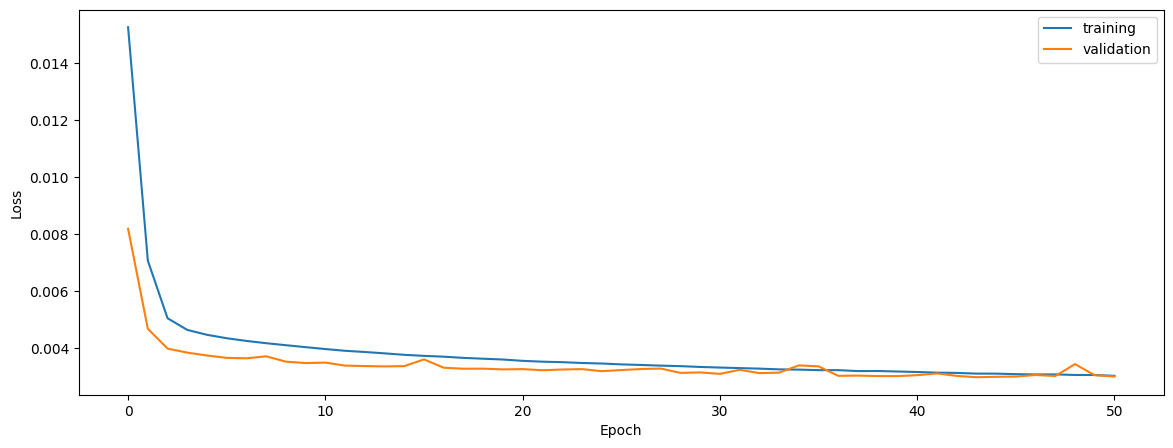

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8184498255437732
0.8095231592178925
0.8092735986408044


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8184498255437732
0.8095231592178925
0.8092735986408044


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8177875136532713
0.8087352885318607
0.8071795178596929


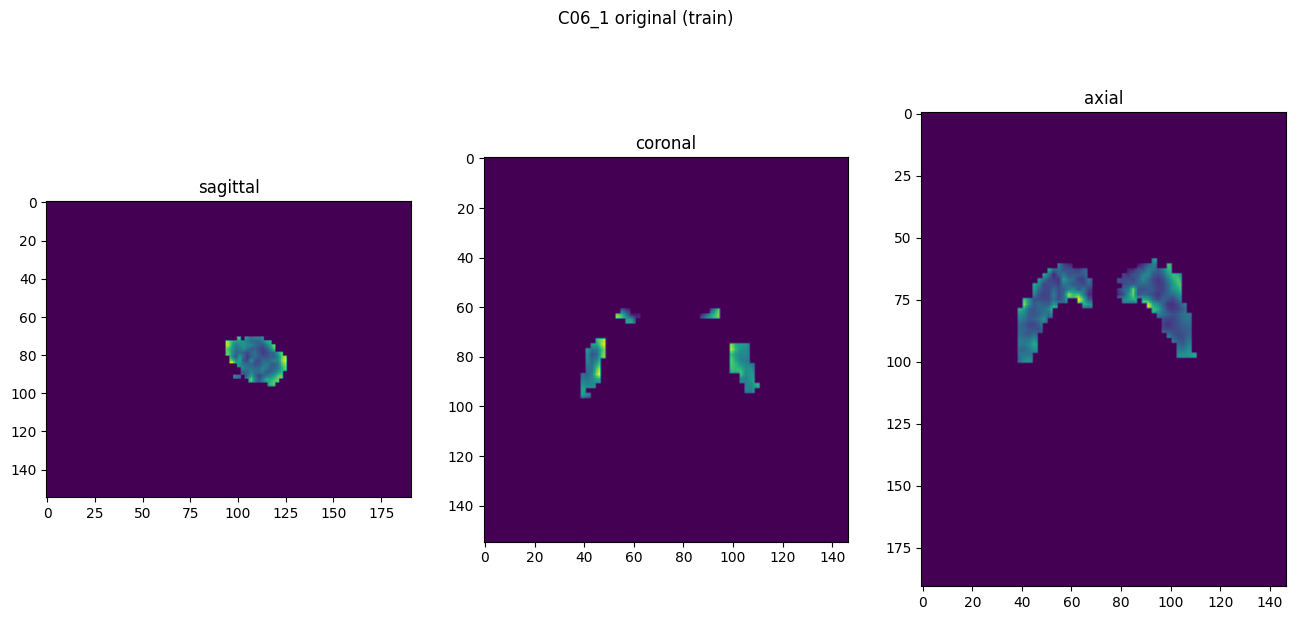

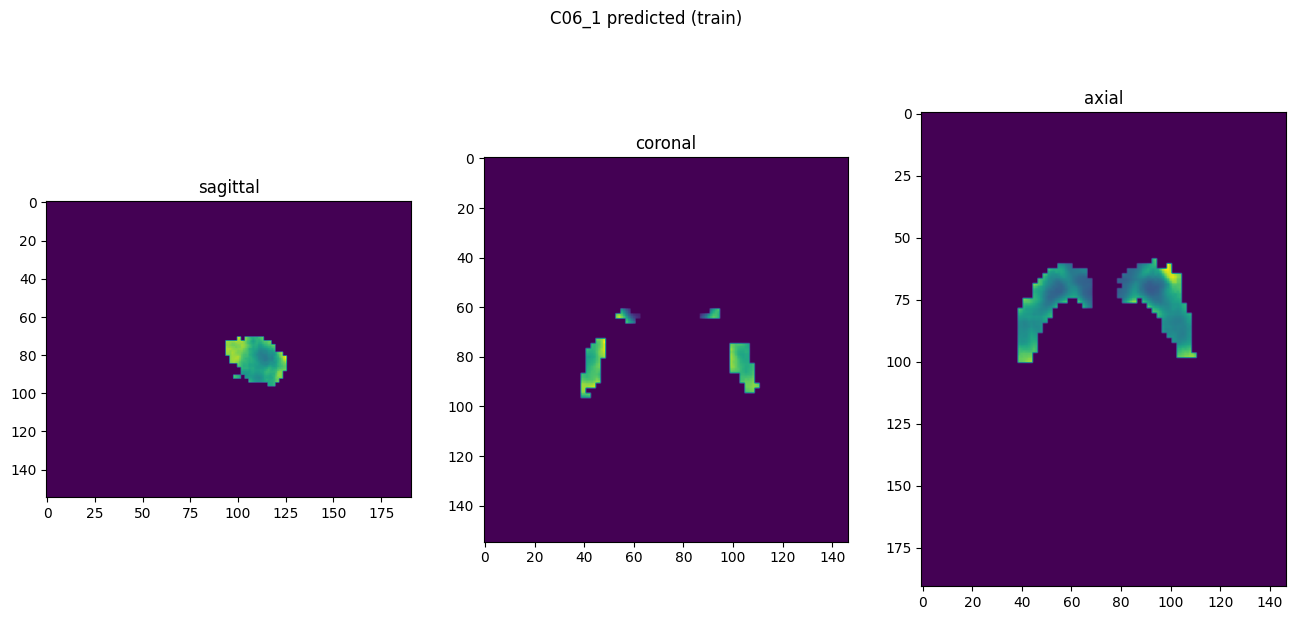

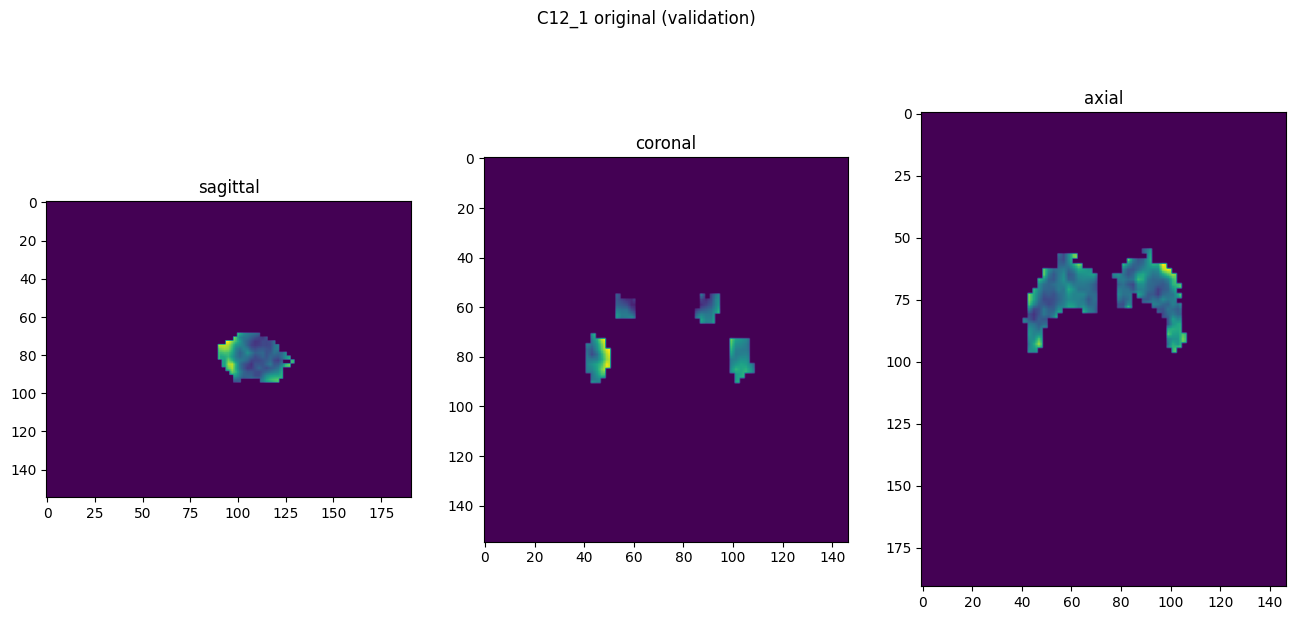

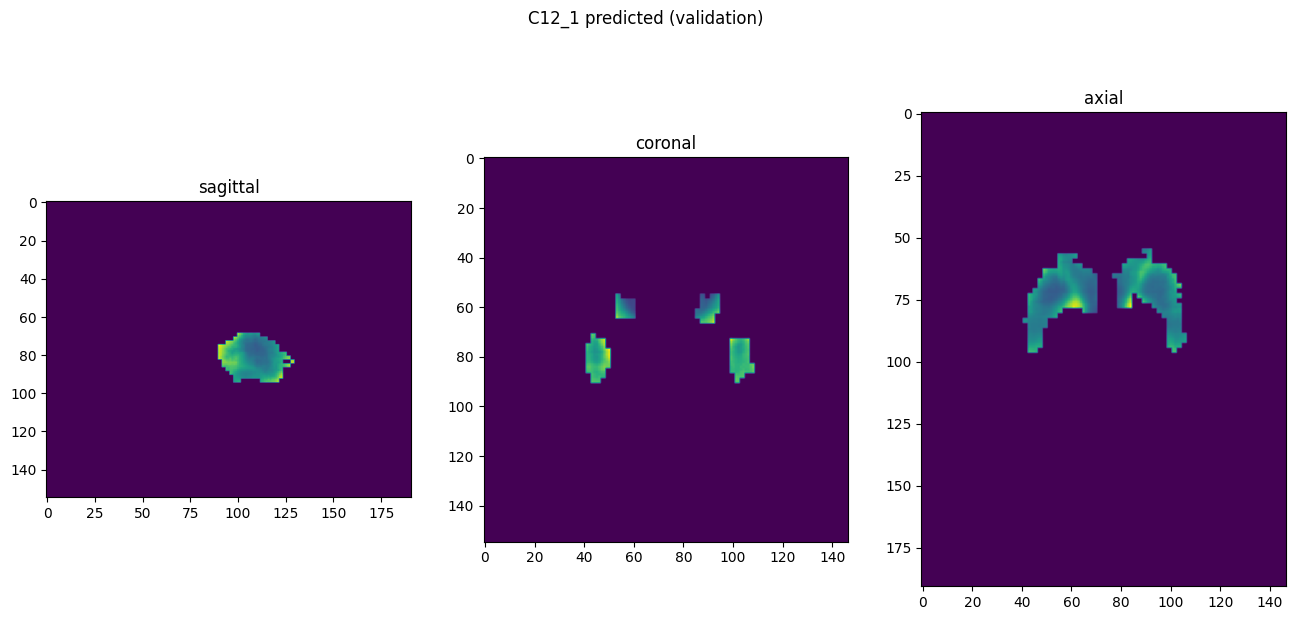

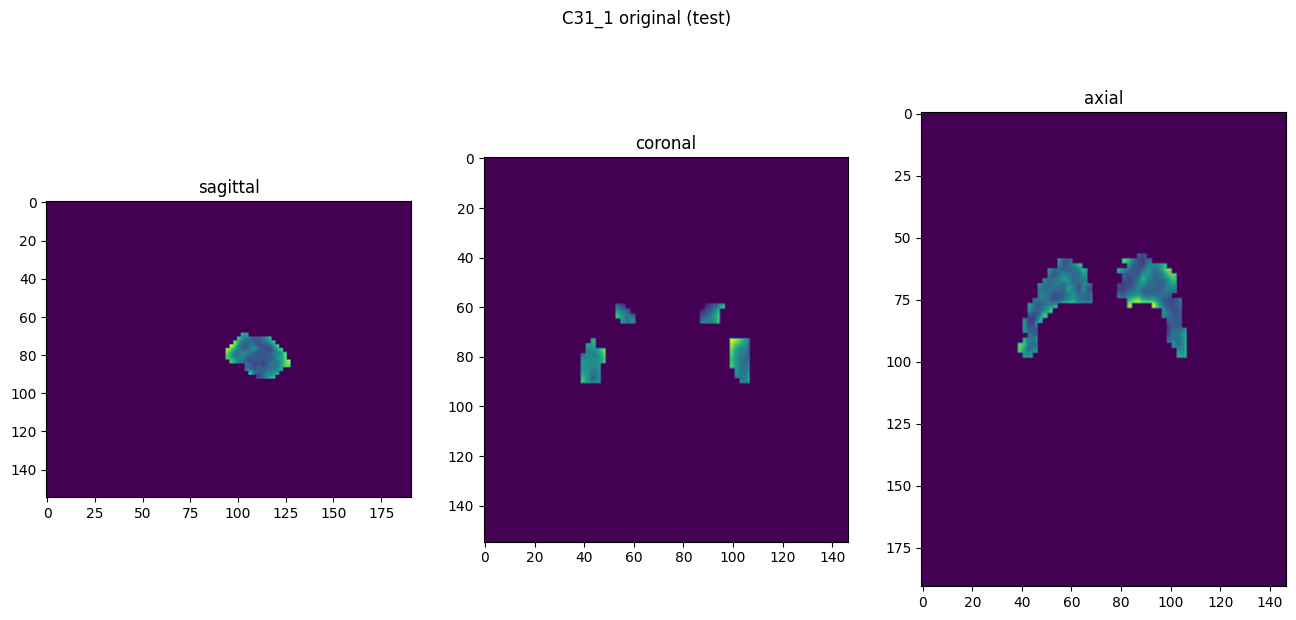

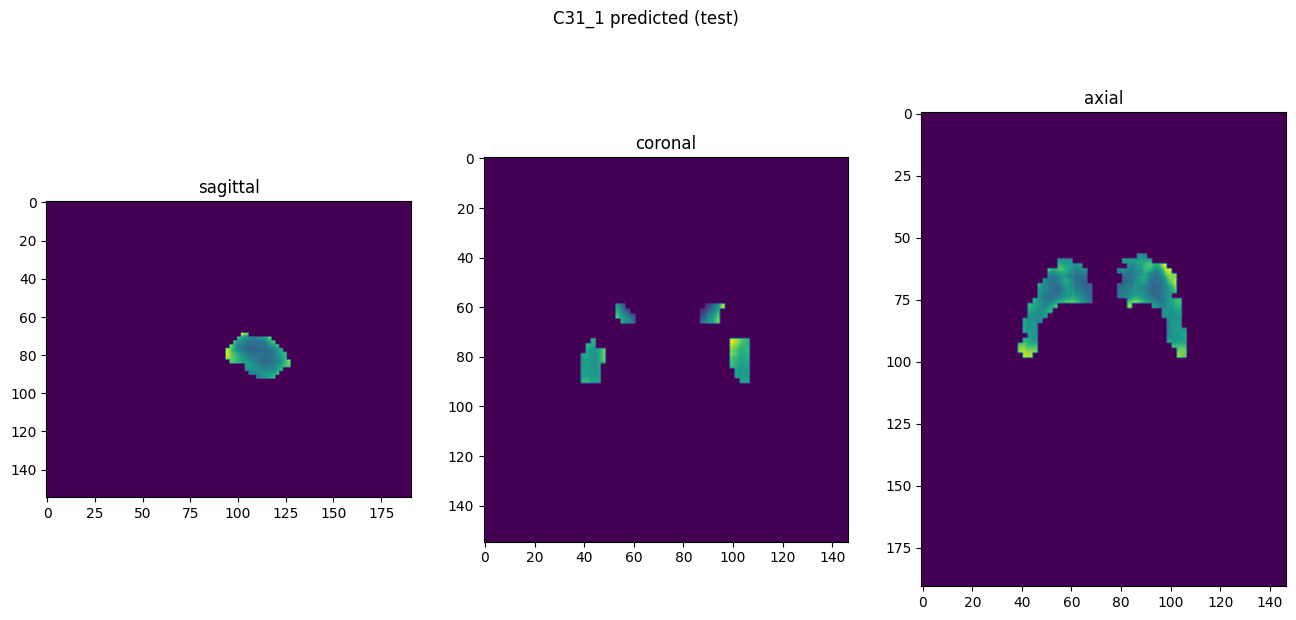

In [10]:
showResults(model, gen, threshold=None, background=False)